In [1]:
import open3d as o3d
import numpy as np
import matplotlib.image as mpimg
import re
from matplotlib import pyplot as plt
import json
import cv2

o3d.t.io.RealSenseSensor.list_devices()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] [0] Intel RealSense D435: 051122073420
[Open3D INFO] 	depth_fps: [100 | 15 | 30 | 300 | 6 | 60 | 90]
[Open3D INFO] 	depth_resolution: [1280,720 | 256,144 | 424,240 | 480,270 | 640,360 | 640,480 | 848,100 | 848,480]
[Open3D INFO] 	depth_format: [RS2_FORMAT_Z16]
[Open3D INFO] 	color_fps: [15 | 30 | 6 | 60]
[Open3D INFO] 	visual_preset: []
[Open3D INFO] 	color_resolution: [1280,720 | 1920,1080 | 320,180 | 320,240 | 424,240 | 640,360 | 640,480 | 848,480 | 960,540]
[Open3D INFO] 	color_format: [RS2_FORMAT_BGR8 | RS2_FORMAT_BGRA8 | RS2_FORMAT_RGB8 | RS2_FORMAT_RGBA8 | RS2_FORMAT_Y16 | RS2_FORMAT_YUYV]
[Open3D INFO] Open3D only supports synchronized color and depth capture (color_fps = depth_fps).


True

In [2]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

In [3]:
string = '''{"serial": "", "color_format": "RS2_FORMAT_RGB8", "color_resolution": "640,480",
             "depth_format": "RS2_FORMAT_Z16", "depth_resolution": "640,480", "fps": "30", "visual_preset": ""}'''
dicta = json.loads(string)
print(dicta)

rs_cfg = o3d.t.io.RealSenseSensorConfig(dicta)
rs = o3d.t.io.RealSenseSensor()
rs.init_sensor(rs_cfg, 0)

{'serial': '', 'color_format': 'RS2_FORMAT_RGB8', 'color_resolution': '640,480', 'depth_format': 'RS2_FORMAT_Z16', 'depth_resolution': '640,480', 'fps': '30', 'visual_preset': ''}


True

In [4]:
rs.start_capture(True)  # true: start recording with capture
for fid in range(1):
    im_rgbd = rs.capture_frame(True, False)  # wait for frames and align them
    # process im_rgbd.depth and im_rgbd.color
rs.stop_capture()
print(im_rgbd)

[Open3D INFO] Capture started with RealSense camera 051122073420
[Open3D INFO] Capture stopped.
RGBD Image pair [Aligned]
Color [size=(640,480), channels=3, format=UInt8, device=CPU:0]
Depth [size=(640,480), channels=1, format=UInt16, device=CPU:0]


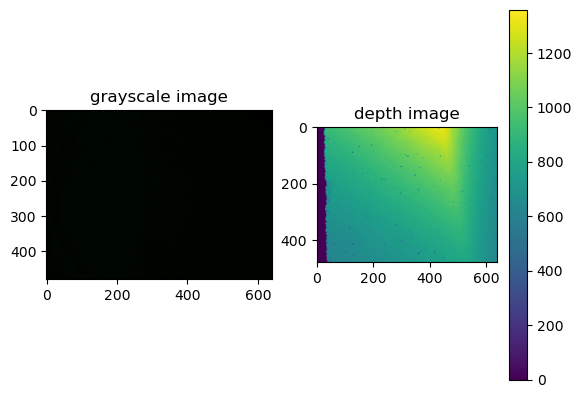

In [5]:
plt.subplot(1, 2, 1)
plt.title('grayscale image')
plt.imshow(im_rgbd.color)
plt.subplot(1, 2, 2)
plt.title('depth image')
plt.imshow(im_rgbd.depth)
plt.colorbar()
plt.show()

In [6]:
def visualize_rgbd(rgbd_image):
    print(rgbd_image)
    o3d.visualization.draw_geometries([rgbd_image])
    
    #intrinsic = o3d.camera.PinholeCameraIntrinsic()
    #intrinsic.intrinsic_matrix =  [[462.1379699707031, 0.0, 320.0], [0.0, 462.1379699707031, 240.0], [0.0, 0.0, 1.0]]
    #intrinsic.intrinsic_matrix =  [[347.99755859375, 0.0, 320.0], [0.0, 347.99755859375, 240.0], [0.0, 0.0, 1.0]]
    #intrinsic.intrinsic_matrix =  [[602.71783447, 0.0, 313.06835938], [0.0, 601.61364746, 230.37461853], [0.0, 0.0, 1.0]]
    w = 640
    h = 480
    fx = 602.71783447
    fy = 601.61364746
    cx = 313.06835938
    cy = 230.37461853
    
    intrinsic = o3d.camera.PinholeCameraIntrinsic(w, h, fx,fy, cx, cy)
    intrinsic.intrinsic_matrix = [[fx, 0, cx], [0, fy, cy], [0, 0, 1]]
    
    cam = o3d.camera.PinholeCameraParameters()
    cam.intrinsic = intrinsic
    
    #cam.extrinsic = np.array([[0., 0., 0., 0.], [0., 0., 0., 0.], [0., 0., 0., 0.], [0., 0., 0., 1.]])
    #pcd = o3d.geometry.create_point_cloud_from_rgbd_image(rgbd_image, cam.intrinsic, cam.extrinsic)
    
    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, cam.intrinsic)
    #pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image,intrinsic)
    
    pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]]) # Flip it, otherwise the pointcloud will be upside down.
    
    o3d.visualization.draw_geometries([pcd])
    
    return pcd
    
    
def tst_dataset(im_rgbd):
    color_raw = o3d.geometry.Image(np.asarray(im_rgbd.color))
    depth_raw = o3d.geometry.Image(np.asarray(im_rgbd.depth))
    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw, depth_raw, convert_rgb_to_intensity=False)
    pcd = visualize_rgbd(rgbd_image)
    return pcd

pt_cloud = tst_dataset(im_rgbd)

RGBDImage of size 
Color image : 640x480, with 3 channels.
Depth image : 640x480, with 1 channels.
Use numpy.asarray to access buffer data.


In [77]:
downpcd = pt_cloud.voxel_down_sample(voxel_size=0.05)
#o3d.visualization.draw_geometries([downpcd])


#pt_cloud.estimate_normals(,search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=4, max_nn=300), fast_normal_computation=True)

print("Recompute the normal of the downsampled point cloud")
downpcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30)) #radius in meters

#o3d.visualization.draw_geometries([downpcd], point_show_normal=True)

v1_normal = np.array(np.asarray(downpcd.normals)) 
v1_normal

Recompute the normal of the downsampled point cloud


array([[-0.34986067, -0.47215888, -0.80911279],
       [-0.36480098, -0.47189134, -0.80264488],
       [ 0.70103828, -0.61224552, -0.36565114],
       ...,
       [ 0.34882614,  0.50592985,  0.78889499],
       [ 0.3549713 ,  0.49820915,  0.79106449],
       [-0.41429141,  0.54137865,  0.73162271]])

In [75]:
print("Align normals towards camera") #orient_normals_towards_camera_location(self, camera_location=array([0.0, 0.0, 0.0]))

downpcd.orient_normals_towards_camera_location()

#o3d.visualization.draw_geometries([downpcd], point_show_normal=True)

v2_camera = np.array(np.asarray(downpcd.normals)) 
v2_camera

Align normals towards camera


array([[ 0.34986067,  0.47215888,  0.80911279],
       [ 0.36480098,  0.47189134,  0.80264488],
       [-0.70103828,  0.61224552,  0.36565114],
       ...,
       [ 0.34882614,  0.50592985,  0.78889499],
       [ 0.3549713 ,  0.49820915,  0.79106449],
       [-0.41429141,  0.54137865,  0.73162271]])

In [82]:
print("Align normals towards tangent plane") 

downpcd.orient_normals_consistent_tangent_plane(1000)
#o3d.visualization.draw_geometries([downpcd], point_show_normal=True)

v3_tangent = np.array(np.asarray(downpcd.normals))
v3_tangent

Align normals towards tangent plane


array([[ 0.34986067,  0.47215888,  0.80911279],
       [ 0.36480098,  0.47189134,  0.80264488],
       [-0.70103828,  0.61224552,  0.36565114],
       ...,
       [ 0.34882614,  0.50592985,  0.78889499],
       [ 0.3549713 ,  0.49820915,  0.79106449],
       [-0.41429141,  0.54137865,  0.73162271]])

In [65]:
print("angle between Normal and Camera,   Normal and Tangent,   Camera and Tangent")
print()
for i in range(len(v3_tangent)):
    print(i+1," ", np.round(np.degrees(angle_between(v1_normal[i], v2_camera[i]))),"                        ", 
               np.round(np.degrees(angle_between(v1_normal[i], v3_tangent[i]))),"                        ",
               np.round(np.degrees(angle_between(v3_tangent[i], v2_camera[i]))) )

angle between Normal and Camera,   Normal and Tangent,   Camera and Tangent

1   180.0                          180.0                          0.0
2   180.0                          180.0                          0.0
3   180.0                          180.0                          0.0
4   180.0                          180.0                          0.0
5   0.0                          0.0                          0.0
6   180.0                          180.0                          0.0
7   180.0                          180.0                          0.0
8   180.0                          180.0                          0.0
9   180.0                          180.0                          0.0
10   180.0                          180.0                          0.0
11   180.0                          180.0                          0.0
12   180.0                          180.0                          0.0
13   180.0                          180.0                          0.0
14   180.0   

http://www.open3d.org/docs/release/python_api/open3d.geometry.PointCloud.html#open3d.geometry.PointCloud.detect_planar_patches

In [74]:
zz = downpcd.detect_planar_patches(normal_variance_threshold_deg=60, coplanarity_deg=75, outlier_ratio=0.75, 
                                   min_plane_edge_length=0.0, min_num_points=0, 
                                   search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
zz

[OrientedBoundingBox: center: (-0.0367456, 0.14059, -0.941583), extent: 0.990167, 0.791331, 0.025993)]

In [76]:
zz = downpcd.detect_planar_patches(normal_variance_threshold_deg=60, coplanarity_deg=75, outlier_ratio=0.75, 
                                   min_plane_edge_length=0.0, min_num_points=0, 
                                   search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
zz

[OrientedBoundingBox: center: (0.22613, 0.0991675, -1.05285), extent: 1.0037, 0.112629, 0.0255997)]

In [84]:
zz = downpcd.detect_planar_patches(normal_variance_threshold_deg=60, coplanarity_deg=75, outlier_ratio=0.75, 
                                   min_plane_edge_length=0.0, min_num_points=0, 
                                   search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
zz

[OrientedBoundingBox: center: (0.22613, 0.0991675, -1.05285), extent: 1.0037, 0.112629, 0.0255997)]

In [86]:
np.degrees(angle_between((0.22613, 0.0991675, -1.05285), (-0.0367456, 0.14059, -0.941583)))

14.611148776214431

In [87]:
np.degrees(angle_between((1.0037, 0.112629, 0.0255997), (0.990167, 0.791331, 0.025993)))

32.22134802836363